In [1]:
import pandas as pd
from sqlalchemy import create_engine

In [2]:
USER = 'ezoji'
PASSWORD = '1qaz!QAZ'
HOST = 'localhost'
PORT = '3306'
NAME = 'pubsub'
con_string = f'mysql://{USER}:{PASSWORD}@{HOST}'
engine = create_engine(con_string)

In [3]:
devices = pd.read_sql('SELECT * FROM pubsub.subpub_emulator_device', engine)

In [4]:
devices

,id,name,device_id,latitude,longitude,status
0,1,device 1,E2280DB7-124F-4895-8BB6-66D5E2B0A686,45.36,36.50,1
1,2,device 2,F366203D-A414-43A8-8E76-50DF0282F5B0,25.30,36.98,0
2,3,device 3,1C71C0C0-0A98-42CF-8351-B4A16E569FF0,56.60,67.90,0


In [5]:
_id = devices.loc[0,'id']
timeseriesdemo = pd.read_sql(f'SELECT * FROM pubsub.subpub_emulator_temperature', engine)
timeseriesdemo.tail()

,id,time,temperature,device_id
1105,1106,1630759413,14,2
1106,1107,1630759415,25,2
1107,1108,1630759417,40,2
1108,1109,1630759419,34,2
1109,1110,1630759421,27,2


In [6]:
#Imports
#msticpy imports
from msticpy.nbtools.timeseries import display_timeseries_anomolies

#pandas
import pandas as pd

#stats library to calculate z-score
from scipy import stats

#statsmodels to use STL for time series decomposition
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

#matplotlib plots for visualization
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rc('figure',figsize=(16,12))
plt.rc('font',size=14)

#For widescreen view
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>")) 

In [7]:
timeseriesdemo.groupby(['device_id'])['temperature'].max()

device_id
1    40
2    40
3    40
Name: temperature, dtype: int64

In [8]:
timeseriesdemo.groupby(['device_id'])['temperature'].count()

device_id
1    508
2    505
3     97
Name: temperature, dtype: int64

In [9]:
import datetime

timeseriesdemo['date'] = timeseriesdemo['time'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
timeseriesdemo['datetime'] = timeseriesdemo['time'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [11]:
timeseriesdemo

,id,time,temperature,device_id,date,datetime
0,1,1630757113,33,1,2021-09-04,2021-09-04 05:05:13
1,2,1630757115,19,1,2021-09-04,2021-09-04 05:05:15
2,3,1630757117,39,1,2021-09-04,2021-09-04 05:05:17
3,4,1630757119,23,1,2021-09-04,2021-09-04 05:05:19
4,5,1630757121,24,1,2021-09-04,2021-09-04 05:05:21
...,...,...,...,...,...,...
1105,1106,1630759413,14,2,2021-09-04,2021-09-04 05:43:33
1106,1107,1630759415,25,2,2021-09-04,2021-09-04 05:43:35
1107,1108,1630759417,40,2,2021-09-04,2021-09-04 05:43:37
1108,1109,1630759419,34,2,2021-09-04,2021-09-04 05:43:39


In [12]:
timeseriesdemo.groupby(['device_id', 'date'])['temperature'].max()

device_id  date      
1          2021-09-04    40
2          2021-09-04    40
3          2021-09-04    40
Name: temperature, dtype: int64

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
timeseriesdemo_agg = pd.DataFrame(timeseriesdemo.groupby(['datetime'])['temperature'].mean())

timeseriesdemo_agg

,temperature
datetime,
2021-09-04 05:05:13,33.0
2021-09-04 05:05:15,19.0
2021-09-04 05:05:17,39.0
2021-09-04 05:05:19,23.0
2021-09-04 05:05:21,24.0
...,...
2021-09-04 05:43:33,14.0
2021-09-04 05:43:35,25.0
2021-09-04 05:43:37,40.0


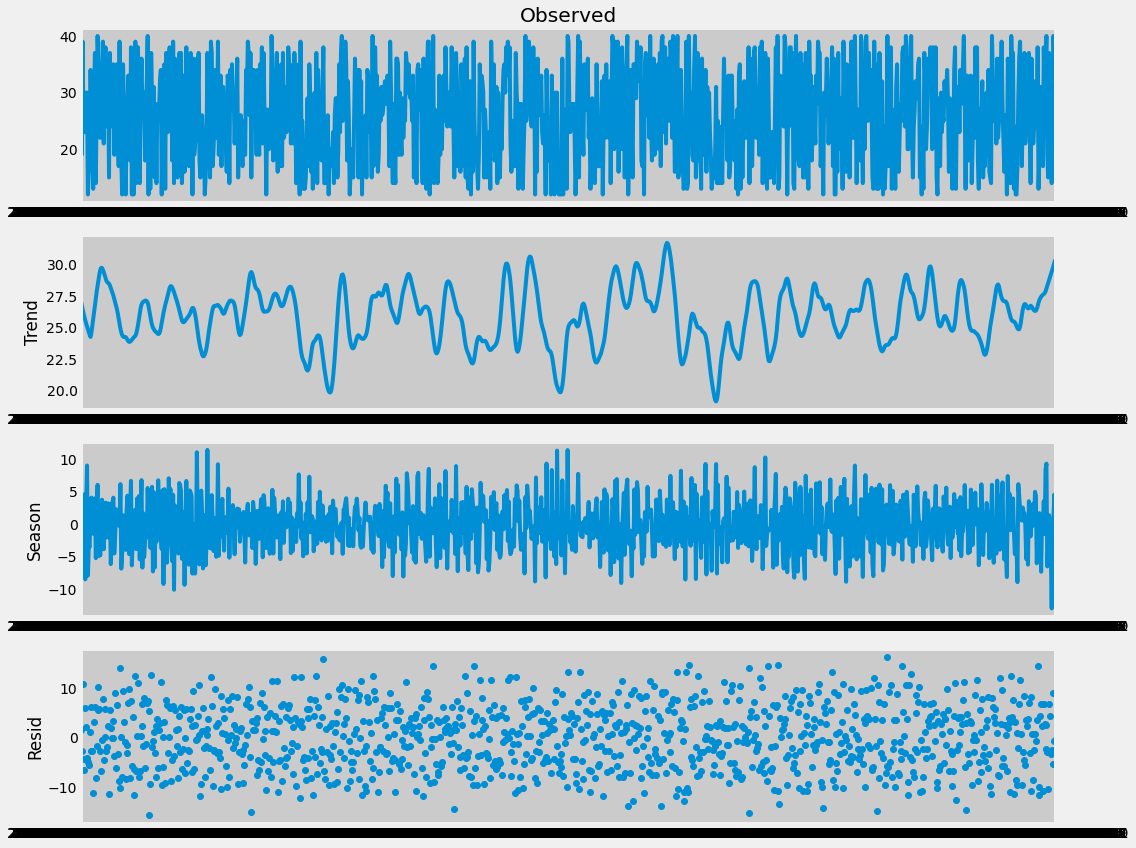

In [14]:
# STL method does Season-Trend decomposition using LOESS
stl = STL(timeseriesdemo_agg, period=12)
#Fitting the data - Estimate season, trend and residuals components.
res = stl.fit()
# Plotting the result from fit method
fig = res.plot()

In [15]:
def tsa_using_stl(data,score_threshold):
    
    output = pd.DataFrame(data.copy())
    
    # Create dataframe columns from decomposition results
    output['residual']= res.resid
    output['trend']= res.trend
    output['seasonal'] = res.seasonal
    output['weights'] = res.weights
    
    #Baseline is generally seasonal + trend 
    output['baseline'] = output['seasonal']+output['trend']
    
    # Type cast and replace na values with 0
    output = output.fillna(0).astype('int64')
    
    # Calculate zscore based on residual column - this column does not contain seasonal/trend components
    output['score'] = stats.zscore(output['residual'])
    
    # create positive and negative columns based on threshold(3) and seasonal components
    output.loc[(output['score'] > score_threshold) & (output['seasonal'] > 0),'anomalies'] = 1
    output.loc[(output['score'] > score_threshold) & (output['seasonal'] < 0),'anomalies'] = -1
    output.loc[(output['score'] < score_threshold),'anomalies'] = 0
    
    #Datatype casting
    output = output.fillna(0).astype('int64')
    output['anomalies']=output['anomalies'].astype('int64')
    output = output.reset_index()
    
    return output

In [16]:
STL_df = tsa_using_stl(timeseriesdemo_agg, 0.2)

#Display sample results
STL_df.head()

,datetime,temperature,residual,trend,seasonal,weights,baseline,score,anomalies
0,2021-09-04 05:05:13,33,1,27,4,1,31,0,0
1,2021-09-04 05:05:15,19,-2,26,-5,1,21,0,0
2,2021-09-04 05:05:17,39,10,26,1,1,28,1,1
3,2021-09-04 05:05:19,23,-4,26,1,1,27,0,0
4,2021-09-04 05:05:21,24,-6,25,4,1,30,-1,0


In [31]:
engine.execute('TRUNCATE TABLE pubsub.data_analysis_stl')

for i in range(len(STL_df)):
    datetime_f = STL_df.loc[i,'datetime']
    temperature = STL_df.loc[i,'temperature']
    residual = STL_df.loc[i,'residual']
    trend = STL_df.loc[i,'trend']
    seasonal = STL_df.loc[i,'seasonal']
    weights = STL_df.loc[i,'weights']
    baseline = STL_df.loc[i,'baseline']
    score = STL_df.loc[i,'score']
    anomalies = STL_df.loc[i,'anomalies']
    insert_q = '''INSERT INTO pubsub.data_analysis_stl
                    (datetime,temperature,residual,trend,seasonal,weights,baseline,score,anomalies)
                    VALUES ('{}',{},{},{},{},{},{},{},{})
        '''.format(datetime_f,temperature,residual,trend,seasonal,weights,baseline,score,anomalies)
        
    engine.execute(insert_q)

<AxesSubplot:>

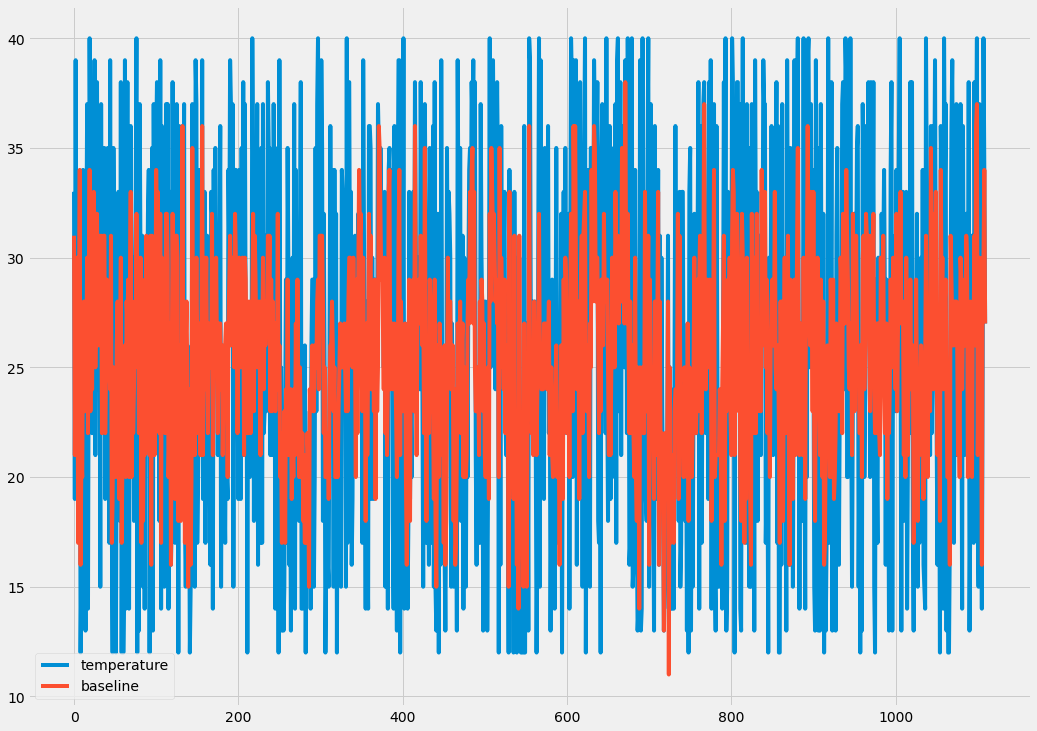

In [32]:
STL_df[['temperature','baseline']].plot()

In [33]:
STL_df['datetime'] = pd.to_datetime(STL_df['datetime'])

In [34]:
timeseries_anomalies_plot = display_timeseries_anomolies(data=STL_df, y="temperature",time_column='datetime')

Loading BokehJS ...

In [36]:
import time
import datetime
d = datetime.date(2015,1,5)

unixtime = time.mktime(d.timetuple())
unixtime

1420444800.0

In [37]:
d

datetime.date(2015, 1, 5)